# Convolutional Neural Network (CNN) for Face Mask Detection

Quick hacky example of putting together a CNN for face mask detection.

In [10]:
import os

import itertools # To join a list of lists

import matplotlib.pyplot as plt # For general plotting

import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

import torchvision
import torchvision.transforms as transforms

# Utility to visualize PyTorch network and shapes
from torchsummary import summary

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
random_seed = 7
np.random.seed(random_seed)
torch.manual_seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

## Data Setting

The intention of this "project" would be to classify whether people are either wearing masks correctly, incorrectly, or not wearing them at all. To create a model for this purpose, like a CNN classifier, we need an appropriate dataset. I pulled the Face Mask Detection (FMD) dataset for this example code from [FMD Kaggle](https://www.kaggle.com/datasets/andrewmvd/face-mask-detection). I load it from the [data](../../data) directory of our code repository.

The code below attempts to get a better understanding of the dataset's properties, e.g. the label distribution. It also performs pre-processing steps, like normalization, for later when we plan to feed this data into a classification model.

c:\Users\Mary Poissant\Documents\GitHub\capstone_cuda\photos_colored_strings_cropped_augmented.pth
Dataset has N = 3110 samples
(array([0, 1, 2, 3, 4, 5, 6]), array([330, 305, 354, 377, 370, 363, 389], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6]), array([83, 76, 89, 94, 92, 91, 97], dtype=int64))
tensor([1, 5, 1, 6, 2, 5, 5, 2, 3, 1, 0, 6, 1, 2, 3, 0, 2, 6, 1, 5, 2, 0, 2, 0,
        2, 4, 5, 3, 6, 2, 2, 6, 1, 1, 3, 0, 0, 5, 5, 3, 4, 1, 3, 6, 2, 1, 3, 2,
        3, 0, 4, 1, 5, 5, 0, 0, 5, 4, 3, 2, 5, 5, 1, 0])

Labels corresponding to randomly drawn images from the training set:
string2	 string6	 string2	 no_string	 string3	 string6	 string6	 string3	


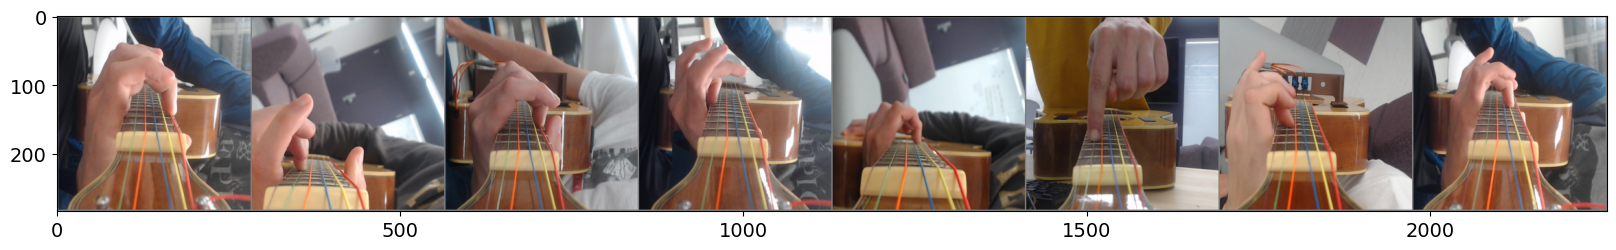

In [11]:
#FOLDER_NAME = 'photos_colored_strings_cropped'
FOLDER_NAME = 'photos_colored_strings_cropped_augmented'
#FOLDER_NAME = 'photos_colored_strings'

# Switch Device
# device = 'cuda'
device = 'cpu'

# Switch to false if there is a model already made and you don't want to continue training
train_model = False

print(os.getcwd() + '\\' + FOLDER_NAME + '.pth')
# Define how transform the data for processing in batches
transform = transforms.Compose([
        transforms.Resize([280,280]), # Resizing the image
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)) # 0.5 due to how torchvision data is in range [0,1]
    ])

# Specify the batch size for SGD
batch_size = 64
# Use the ImageFolder class, which is a generic dataloder useful when images stored in labelled directories
# Apply transform to images specified above, importantly converting "ToTensor"
dataset = torchvision.datasets.ImageFolder(root=FOLDER_NAME, transform=transform)
# Specify classes for convenience in printing
classes = ('string1', 'string2', 'string3', 'string4', 'string5', 'string6', 'no_string')
print("Dataset has N = {} samples".format(len(dataset)))

# List of targets/labels for entire dataset
targets = dataset.targets
# Use sklearn function to split the data into training-test sets (80-20 split)
# Stratified ensures that same percentage of samples of each target class form a complete set
train_idx, test_idx= train_test_split(
    np.arange(len(targets)), test_size=0.2, random_state=random_seed, shuffle=True, stratify=targets)

# Printing the unique class labels in each split set and the number of occurrences per class
print(np.unique(np.array(targets)[train_idx], return_counts=True))
print(np.unique(np.array(targets)[test_idx], return_counts=True))

# Create training and test subsets based on split indices
train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

# Define iterable for our newly created dataset and shuffle samples 
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

### Plotting stuff for visualization ###
fig = plt.figure(figsize=(20,20))
# Utility function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    img_np = img.numpy()
    plt.imshow(np.transpose(img_np, (1, 2, 0)))

# Get some random training dataset images
dataiter = iter(train_dataloader)
# Extract a batch
images, labels = dataiter.next()
print(labels)
# Show 8 images for display
num_display = 8
imshow(torchvision.utils.make_grid(images[:num_display]))
# Print labels as a concatenated string
print("\nLabels corresponding to randomly drawn images from the training set:")
print(" ".join(f'{classes[labels[j]]:5s}\t' for j in range(num_display)))

In [12]:
from torchvision import models

model = models.vgg16(pretrained=True).to(device)

# Freeze early layers
for param in model.parameters():
    param.requires_grad = False

n_inputs = model.classifier[6].in_features

# Add on classifier
n_classes = 7
model.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.4),
    nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

model.classifier

if device == 'cuda':
    model = model.to('cuda')

c:\Users\Mary Poissant\anaconda3\envs\capstone\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\Mary Poissant\anaconda3\envs\capstone\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
def get_pretrained_model(model_name):
    """Retrieve a pre-trained model from torchvision

    Params
    -------
        model_name (str): name of the model (currently only accepts vgg16 and resnet50)

    Return
    --------
        model (PyTorch model): cnn

    """

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features

        # Add on classifier
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False

        n_inputs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    # Move to gpu and parallelize
    if device == "cuda":
        model = model.to('cuda')

    return model

In [14]:
model = get_pretrained_model('vgg16')
summary(model, input_size=(3, 224, 224), batch_size=batch_size, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 64, 224, 224]           1,792
              ReLU-2         [64, 64, 224, 224]               0
            Conv2d-3         [64, 64, 224, 224]          36,928
              ReLU-4         [64, 64, 224, 224]               0
         MaxPool2d-5         [64, 64, 112, 112]               0
            Conv2d-6        [64, 128, 112, 112]          73,856
              ReLU-7        [64, 128, 112, 112]               0
            Conv2d-8        [64, 128, 112, 112]         147,584
              ReLU-9        [64, 128, 112, 112]               0
        MaxPool2d-10          [64, 128, 56, 56]               0
           Conv2d-11          [64, 256, 56, 56]         295,168
             ReLU-12          [64, 256, 56, 56]               0
           Conv2d-13          [64, 256, 56, 56]         590,080
             ReLU-14          [64, 256,

In [15]:
print(model.classifier[6])

Sequential(
  (0): Linear(in_features=4096, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=256, out_features=7, bias=True)
  (4): LogSoftmax(dim=1)
)


In [18]:
model.class_to_idx = dataset.class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())

[(0, 'no_string'),
 (1, 'string1'),
 (2, 'string2'),
 (3, 'string3'),
 (4, 'string4'),
 (5, 'string5'),
 (6, 'string6')]

In [20]:
from torch import optim

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

In [21]:
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([256, 4096])
torch.Size([256])
torch.Size([7, 256])
torch.Size([7])


In [22]:
import pandas as pd
from timeit import default_timer as timer

def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if device == "cuda":
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if device == "cuda":
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [23]:
save_file_name = 'vgg16-transfer-4.pt'

model, history = train(
    model,
    criterion,
    optimizer,
    train_dataloader,
    test_dataloader,
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=10,
    print_every=2)

Starting Training from Scratch.

Epoch: 1	100.00% complete. 845.79 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.8791 	Validation Loss: 0.6076
		Training Accuracy: 66.96%	 Validation Accuracy: 82.15%
Epoch: 3	100.00% complete. 820.01 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.6809 	Validation Loss: 0.4450
		Training Accuracy: 74.28%	 Validation Accuracy: 88.42%
Epoch: 5	100.00% complete. 821.22 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.5628 	Validation Loss: 0.3878
		Training Accuracy: 78.50%	 Validation Accuracy: 89.39%
Epoch: 7	100.00% complete. 811.81 seconds elapsed in epoch.
Epoch: 7 	Training Loss: 0.5043 	Validation Loss: 0.3315
		Training Accuracy: 80.59%	 Validation Accuracy: 91.16%
Epoch: 9	100.00% complete. 809.68 seconds elapsed in epoch.
Epoch: 9 	Training Loss: 0.4886 	Validation Loss: 0.3278
		Training Accuracy: 82.19%	 Validation Accuracy: 90.51%
Epoch: 11	100.00% complete. 822.76 seconds elapsed in epoch.
Epoch: 11 	Training Loss: 0.4375 	Va

KeyboardInterrupt: 

In [24]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

NameError: name 'history' is not defined

<Figure size 800x600 with 0 Axes>

In [ ]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')